# Duration of Sick Notes and Associated Diagnoses

This notebook provides descriptive statistics (mean and median) of the duration of sick notes and compares diagnoses associated with sick notes across COVID and comparator cohorts.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth',1000)

In [2]:
# Function to parse string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def round_seven(x, base=7):
    return base * round(x/base)

In [3]:
# Read in and append input files
li = []

for file in glob('../output/cohorts/cohort_rates*.dta'):
    df_temp = pd.read_stata(file)
    # Creates date variable based on file name
    df_temp['cohort'] = file[find_nth(file, '_', 2)+1:-4]
    # Create population count
    df_temp['population'] = 1
    li.append(df_temp)
    
df_temp = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

# hospitalised COVID cohorts
covid_hosp_2020 = df_temp.loc[(~df_temp.hosp_expo_date.isna()) & (df_temp.cohort == 'covid_2020')]
covid_hosp_2020.cohort = 'covid_hosp_2020'
li.append(covid_hosp_2020)

covid_hosp_2021 = df_temp.loc[(~df_temp.hosp_expo_date.isna()) & (df_temp.cohort == 'covid_2021')]
covid_hosp_2021.cohort = 'covid_hosp_2021'
li.append(covid_hosp_2021)

df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [4]:
# Do not count those who had sick notes beyond end dates
df_input.loc[df_input.sick_note == 0, 'first_sick_note_duration'] = np.nan

In [5]:
# Columns to subset
diag_cols = [col for col in df_input if col.startswith('diag_')]
subset_cols = ['cohort','age_group','sex',
               'ethnicity','imd','region_string',
               'first_sick_note_duration',
               'sick_note','population'] + diag_cols

# Subset to relevant columns and do not count those beyond 
df_clean = df_input[subset_cols].rename(columns={'region_string':'region'})

In [6]:
# Clean cohort names
dict_cohort_names = {'covid_2020':'COVID patients (2020)', 
                     'covid_2021':'COVID patients (2021)', 
                     'covid_hosp_2020':'Hospitalised COVID patients (2020)', 
                     'covid_hosp_2021':'Hospitalised COVID patients (2021)', 
                     'general_2019':'General population (2019)', 
                     'general_2020':'General population (2020)', 
                     'general_2021':'General population (2021)', 
                     'pneumonia_2019':'Hospitalised pneumonia patients (2019)'}
df_clean = df_clean.replace({"cohort": dict_cohort_names})

_____

## Duration

In [7]:
def compute_med_mean(path, demo=''):
    groups = ['cohort']
    if demo != '': 
        groups = ['cohort', demo]
    df_pct_ct = df_clean.groupby(
        groups)[['sick_note','population']].sum().reset_index()
    df_med = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmedian).reset_index().rename(columns={0:'median_duration'})
    df_mean = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmean).reset_index().rename(columns={0:'mean_duration'})
    df_pct25 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,25)).reset_index().rename(columns={0:'pct_25'})
    df_pct75 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,75)).reset_index().rename(columns={0:'pct_75'})
    dfs = [df_pct_ct, df_med, df_mean, df_pct25, df_pct75]
    df_out = reduce(
        lambda left,right: pd.merge(left,right,on=groups), dfs
    )
    # Redact if sick notes or population count <= 5 
    df_out = df_out.loc[(df_out['population'] > 7) & (df_out['sick_note'] > 7)]
    df_out['population'] = df_out['population'].apply(lambda x: round_seven(x))
    df_out['sick_note'] = df_out['sick_note'].apply(lambda x: round_seven(x))
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    df_out.to_csv('../output/tabfig/' + path + '.csv', index=False)
    return df_out

In [8]:
# Overall
compute_med_mean('med_mean_overall')

,cohort,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),560,1150,270.0,273.994633,226.5,322.50
1,COVID patients (2021),1595,2050,270.0,270.925972,224.0,318.75
2,General population (2019),440,1135,272.0,280.444191,226.0,326.00
3,General population (2020),355,650,267.0,270.535014,211.0,317.00
4,General population (2021),860,1105,274.0,272.430572,223.0,317.00
5,Hospitalised COVID patients (2020),215,420,271.0,268.152778,215.5,320.00
6,Hospitalised COVID patients (2021),585,765,274.0,273.756849,228.0,319.00
7,Hospitalised pneumonia patients (2019),145,390,258.0,248.600000,199.0,302.00


In [9]:
# Age group
compute_med_mean('med_mean_age_group', 'age_group')

,cohort,age_group,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),0-17,50,115,261.0,266.750000,217.00,307.50
1,COVID patients (2020),18-24,55,115,266.0,268.886792,224.00,310.00
2,COVID patients (2020),25-34,45,115,273.0,276.340426,232.50,320.00
3,COVID patients (2020),35-44,70,135,262.0,256.436620,200.50,313.50
4,COVID patients (2020),45-54,105,230,276.0,295.019048,239.00,330.00
5,COVID patients (2020),55-69,120,225,269.0,273.256198,231.00,325.00
6,COVID patients (2020),70-79,60,110,266.5,262.916667,230.00,307.25
7,COVID patients (2020),80+,50,110,283.0,280.600000,234.50,324.75
8,COVID patients (2021),0-17,145,195,271.0,262.401361,222.00,316.50
9,COVID patients (2021),18-24,150,200,257.5,261.756579,217.75,315.00


In [10]:
# Sex
compute_med_mean('med_mean_sex', 'sex')

,cohort,sex,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),F,285,590,270.0,274.533333,228.00,322.00
1,COVID patients (2020),M,275,560,271.0,273.434307,224.50,322.75
2,COVID patients (2021),F,805,1020,270.0,272.041096,224.00,319.00
3,COVID patients (2021),M,790,1030,270.0,269.793932,223.50,315.50
4,General population (2019),F,215,570,274.0,286.102326,231.50,328.00
5,General population (2019),M,225,565,270.5,275.013393,223.75,323.50
6,General population (2020),F,170,315,267.0,270.773256,215.00,317.00
7,General population (2020),M,185,335,266.0,270.313514,209.00,318.00
8,General population (2021),F,430,555,275.0,271.758140,216.25,318.75
9,General population (2021),M,425,550,273.0,273.107728,225.50,316.00


In [11]:
# Ethnicity
compute_med_mean('med_mean_ethnicity', 'ethnicity')

,cohort,ethnicity,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),White,340,700,272.0,276.943953,226.50,318.00
1,COVID patients (2020),Asian or Asian British,35,75,264.0,248.735294,218.00,295.25
2,COVID patients (2020),Other,50,95,262.0,279.877551,230.00,330.00
3,COVID patients (2020),Unknown,135,280,269.0,270.861314,227.00,325.00
4,COVID patients (2021),White,935,1200,271.0,272.641026,225.75,317.50
5,COVID patients (2021),Asian or Asian British,115,145,272.0,266.991150,218.00,319.00
6,COVID patients (2021),Other,130,165,282.0,289.596899,235.00,345.00
7,COVID patients (2021),Unknown,415,540,263.0,262.346154,218.50,312.00
8,General population (2019),White,245,660,275.0,284.097561,232.50,325.75
9,General population (2019),Asian or Asian British,25,75,277.0,295.000000,221.00,301.75


In [12]:
# IMD
compute_med_mean('med_mean_imd', 'imd')

,cohort,imd,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),0,35,65,261.0,244.270270,218.00,288.00
1,COVID patients (2020),1,105,220,260.0,270.869159,222.50,314.00
2,COVID patients (2020),2,90,200,268.0,277.619565,223.75,320.50
3,COVID patients (2020),3,105,225,268.0,279.207547,228.25,325.25
4,COVID patients (2020),4,100,220,284.0,284.617647,231.75,340.50
5,COVID patients (2020),5,115,225,276.0,269.339130,230.00,317.00
6,COVID patients (2021),0,85,115,282.0,277.642857,229.75,321.00
7,COVID patients (2021),1,315,410,267.0,270.450479,220.00,314.00
8,COVID patients (2021),2,280,350,268.0,264.615108,219.00,318.00
9,COVID patients (2021),3,280,365,287.0,287.523132,238.00,333.00


In [13]:
# Region
compute_med_mean('med_mean_region', 'region')

,cohort,region,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),East,50,110,271.0,284.490196,236.00,331.50
1,COVID patients (2020),East Midlands,55,120,269.0,269.178571,233.00,324.00
2,COVID patients (2020),London,115,255,275.0,283.606838,224.00,331.00
3,COVID patients (2020),North East,55,100,269.5,286.607143,231.00,297.50
4,COVID patients (2020),North West,50,115,263.5,270.104167,231.75,314.25
5,COVID patients (2020),South East,65,130,271.5,287.015152,219.50,333.75
6,COVID patients (2020),South West,50,105,275.0,262.857143,213.00,311.00
7,COVID patients (2020),West Midlands,55,115,273.0,261.945455,234.00,317.50
8,COVID patients (2020),Yorkshire and The Humber,60,105,258.0,248.409836,215.00,294.00
9,COVID patients (2021),East,160,210,277.0,267.316770,230.00,314.00


_______

## Associated Diagnoses

### Percentage of Sick Notes by Diagnostic Category

In [14]:
def create_subplot(measure, df_in, ax):
    # Create barplot
    sns.barplot(x=measure, y='cohort', data=df_in, ax=ax, orient='h')
    # Set title and axes labels
    ax.set_xlabel('% of Sick Notes')
    ax.set_ylabel('Cohort')
    
def create_plotgrid(measure, df_in):
    fig, ax = plt.subplots(figsize=(12,8))
    create_subplot('pct_'+measure, df_in, ax)
    # Title
    title = measure[5:].replace("_", " ").title()
    ax.title.set_text(title) 
    plt.show()
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    fig.savefig('../output/tabfig/' + measure + '.png')

In [15]:
# Create flag
for c in diag_cols:
    df_clean['num_' + c] = 0
    df_clean.loc[~df_clean[c].isna(), 'num_' + c] = 1

# Sum sick notes and diagnoses by cohort
num_diag_cols = [col for col in df_clean if col.startswith('num_diag_')]
diag_subset_cols = ['cohort', 'sick_note'] + num_diag_cols
df_diag = df_clean[diag_subset_cols]
df_diag_sum = df_diag.groupby('cohort').sum().reset_index()

# Proportion of sick notes by diagnoses
for c in num_diag_cols:
    df_diag_sum['pct_diag_' + c[9:]] = (df_diag_sum[c]/df_diag_sum['sick_note'])*100
pct_cols = [col for col in df_diag_sum if col.startswith('pct_diag_')]

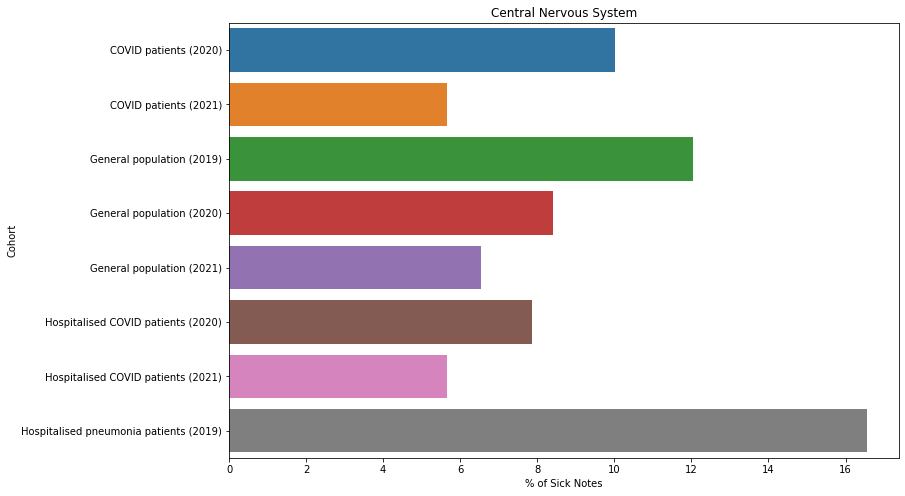

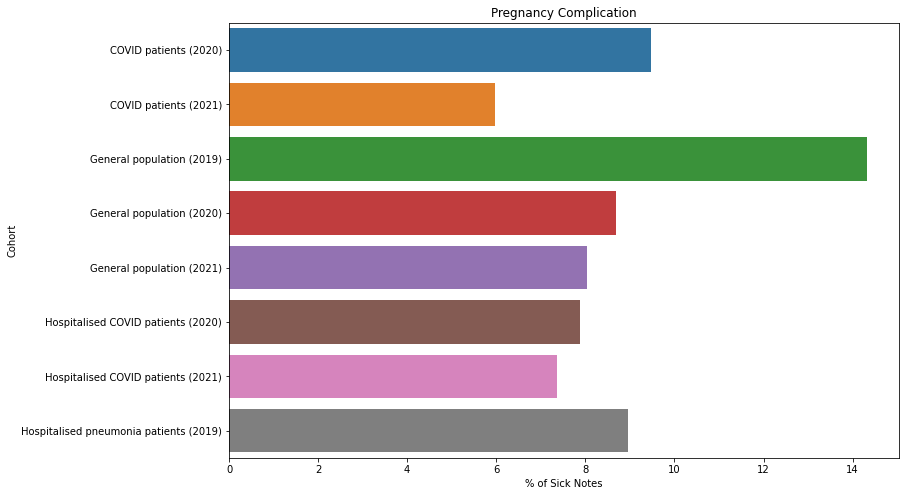

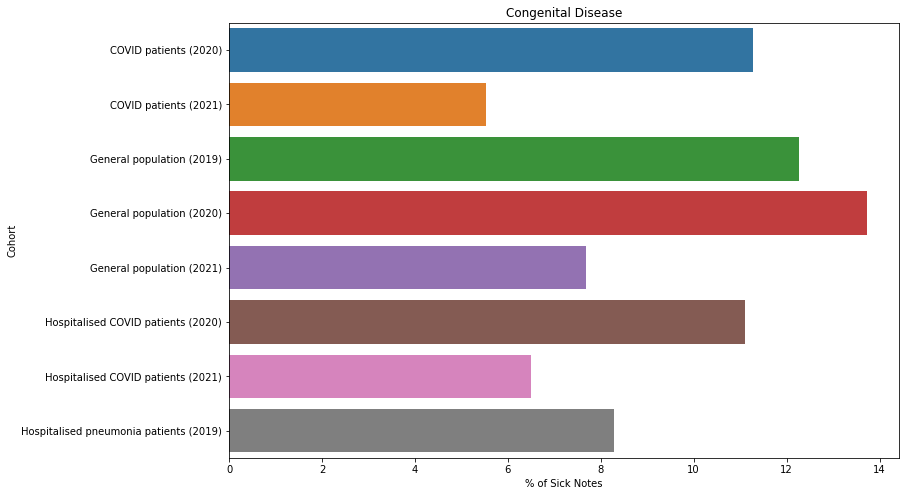

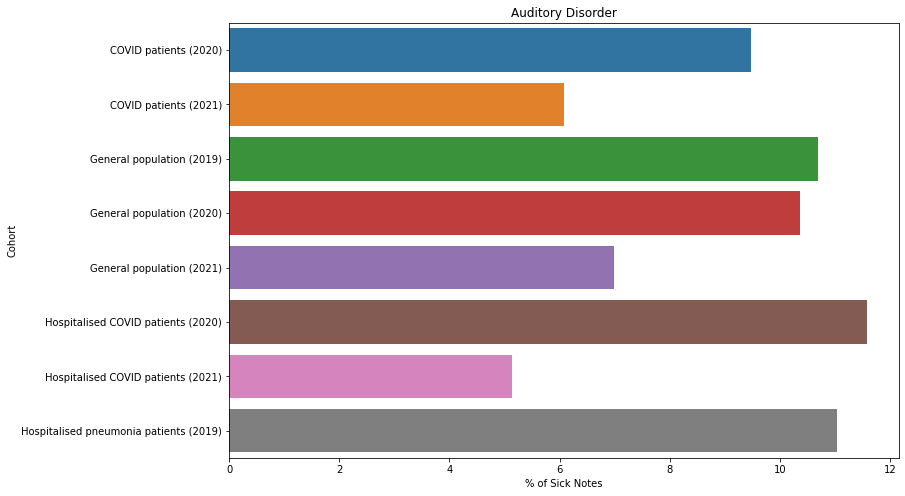

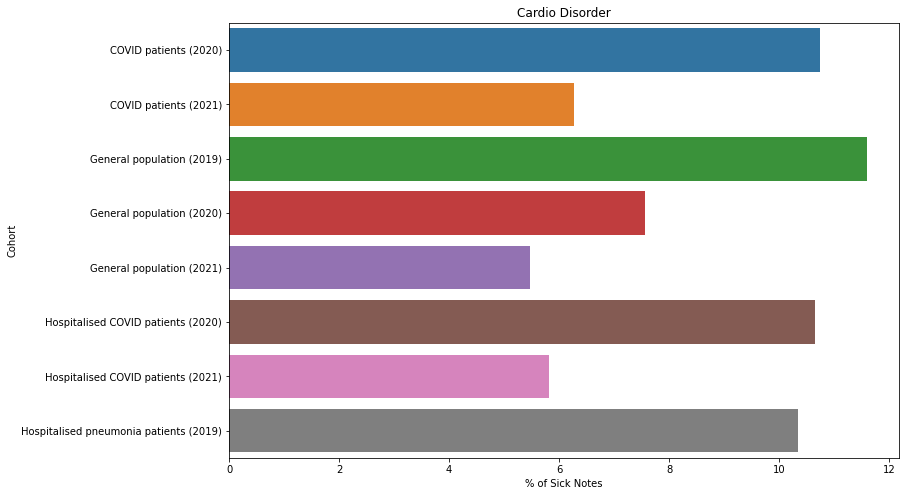

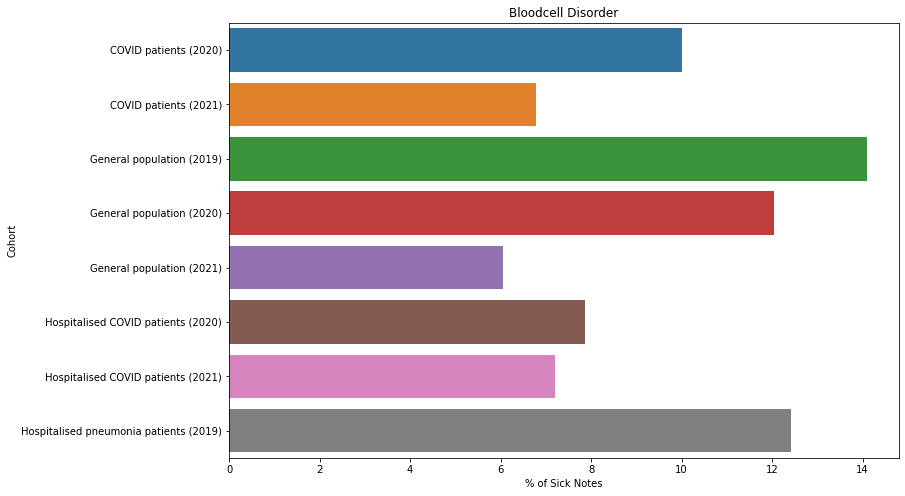

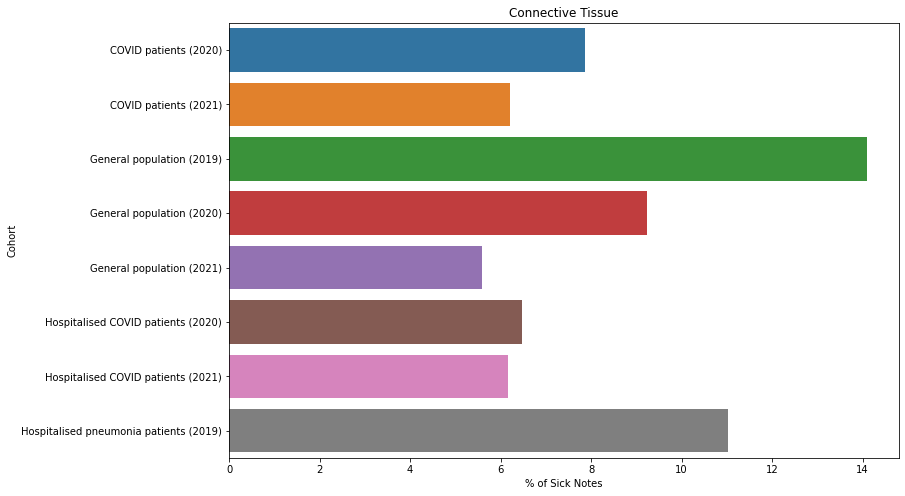

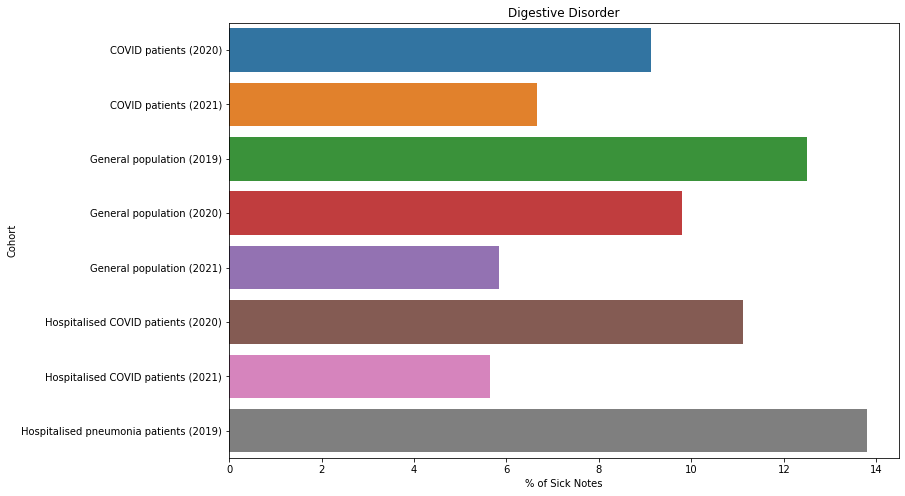

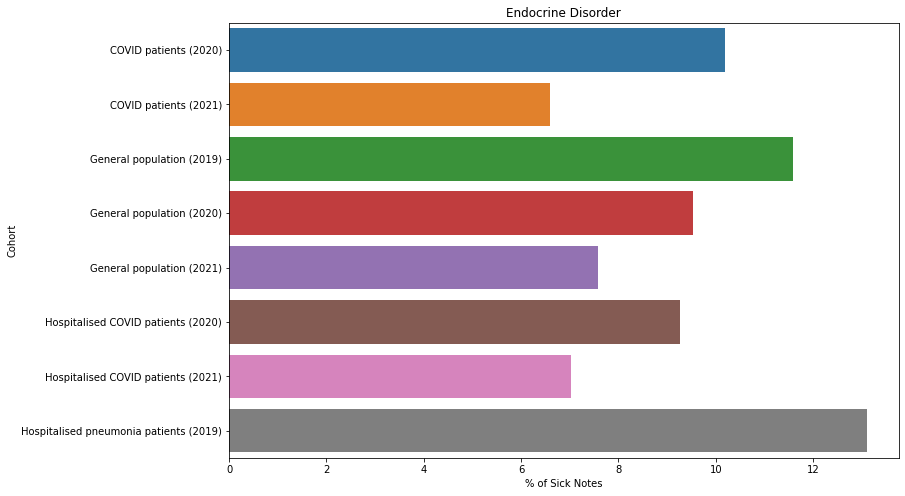

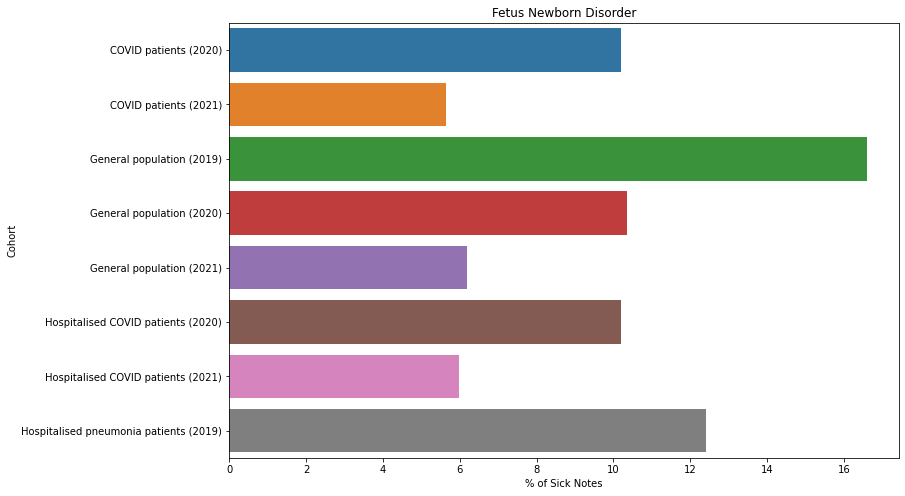

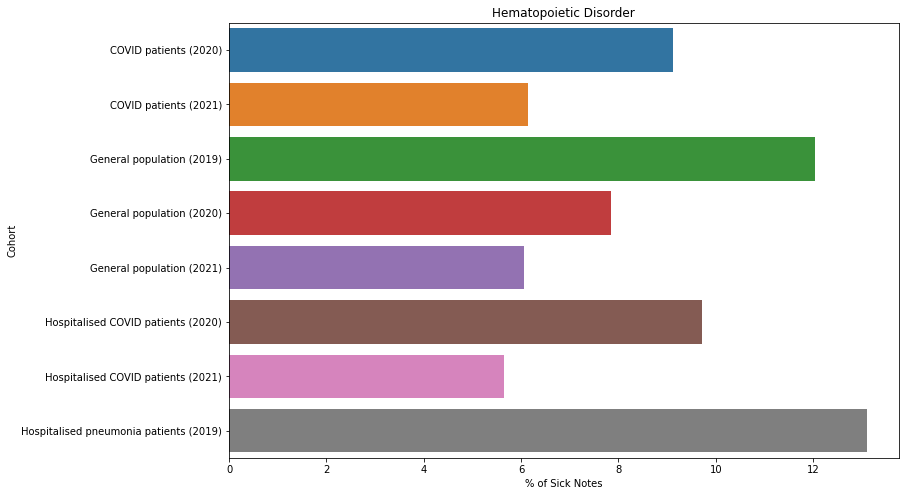

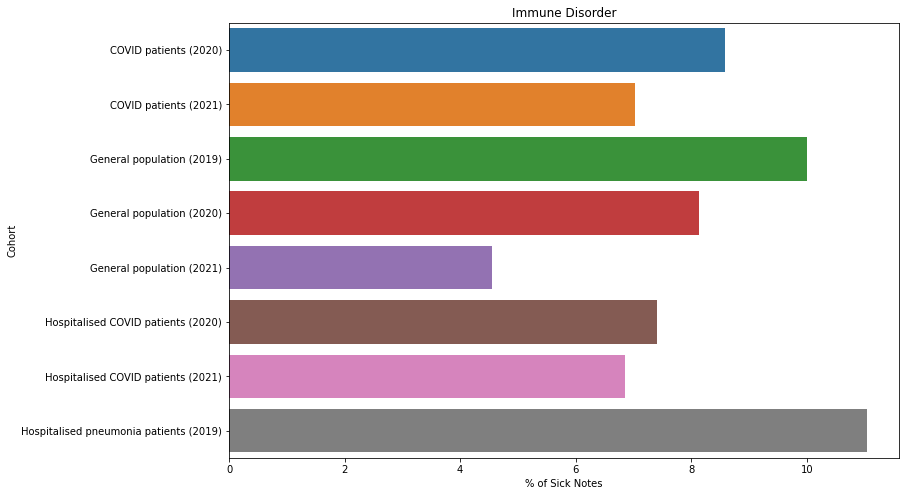

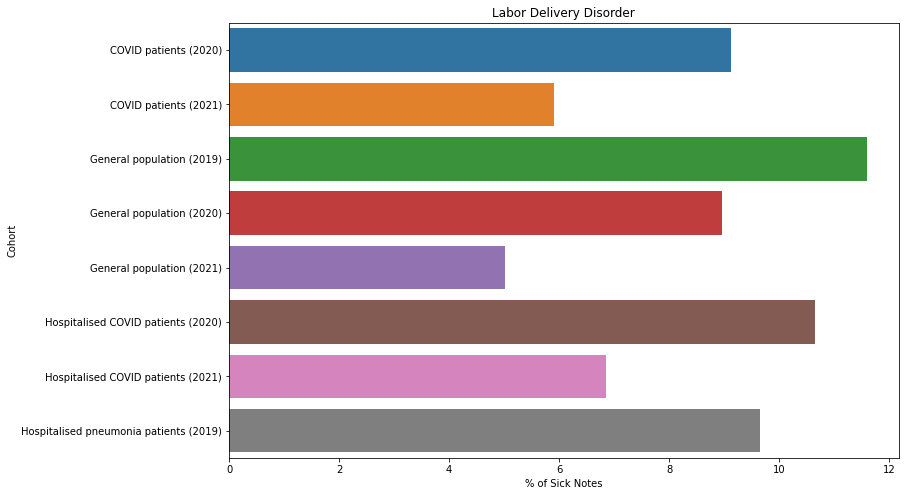

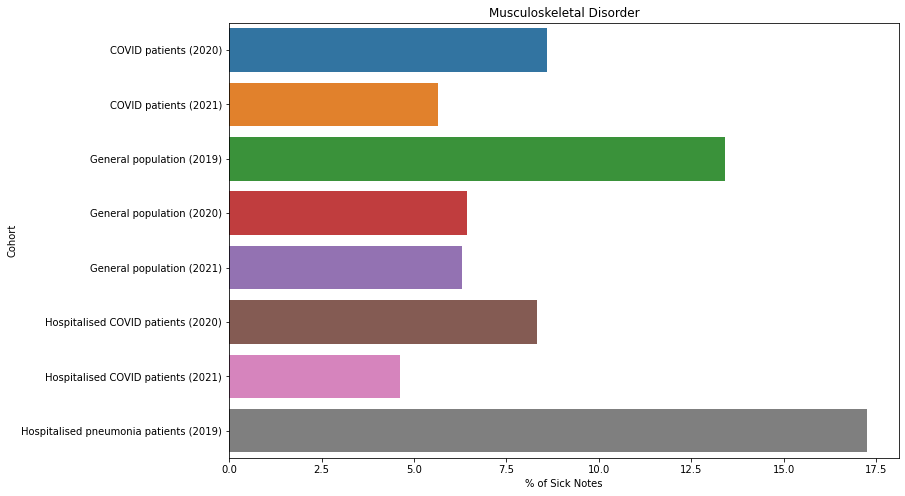

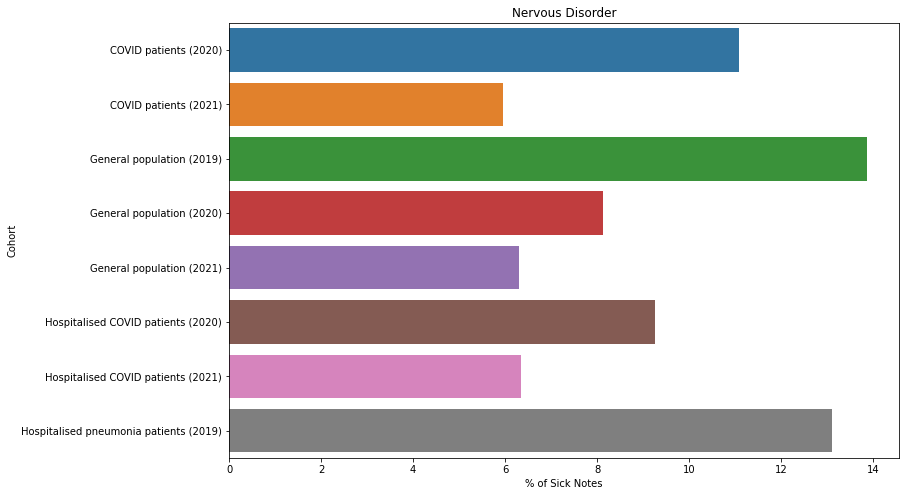

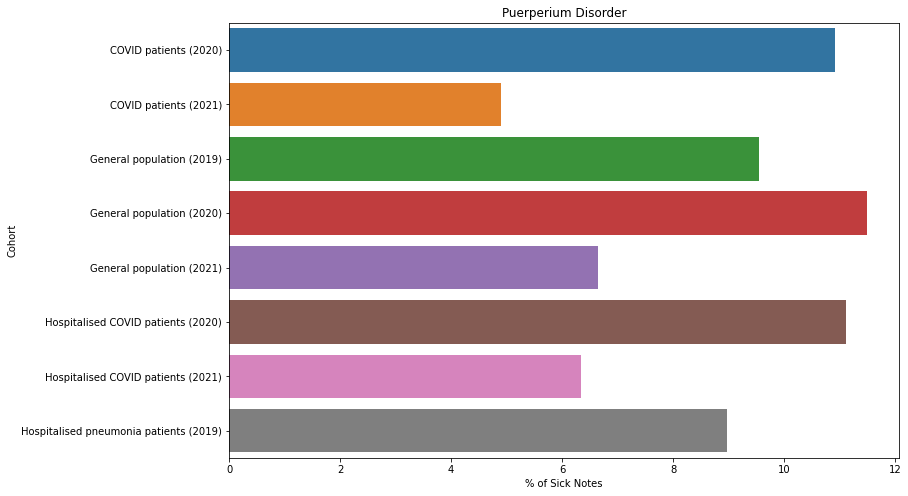

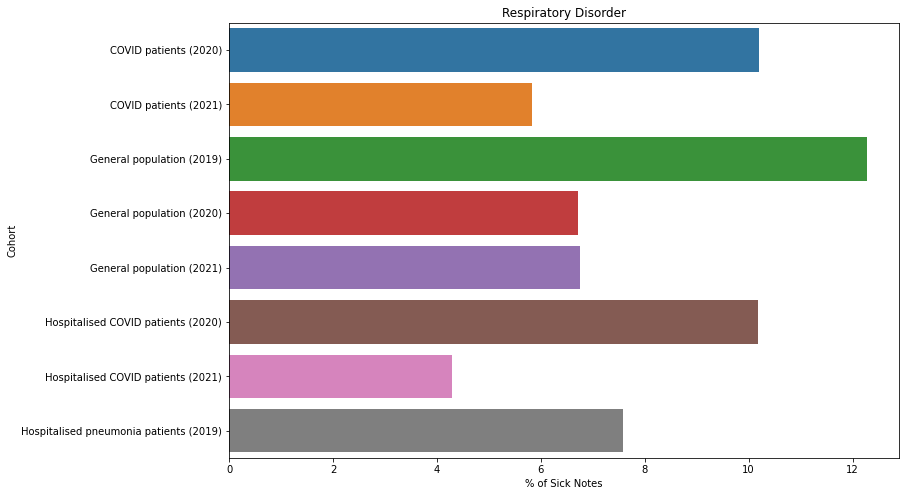

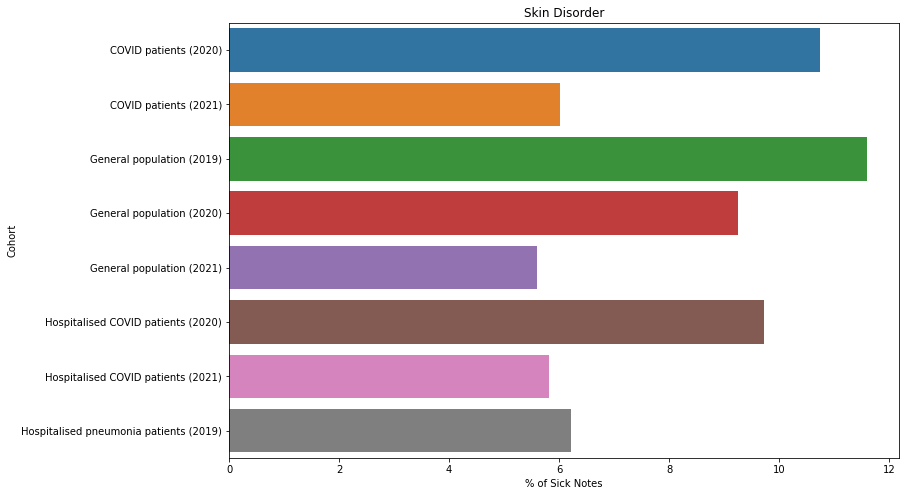

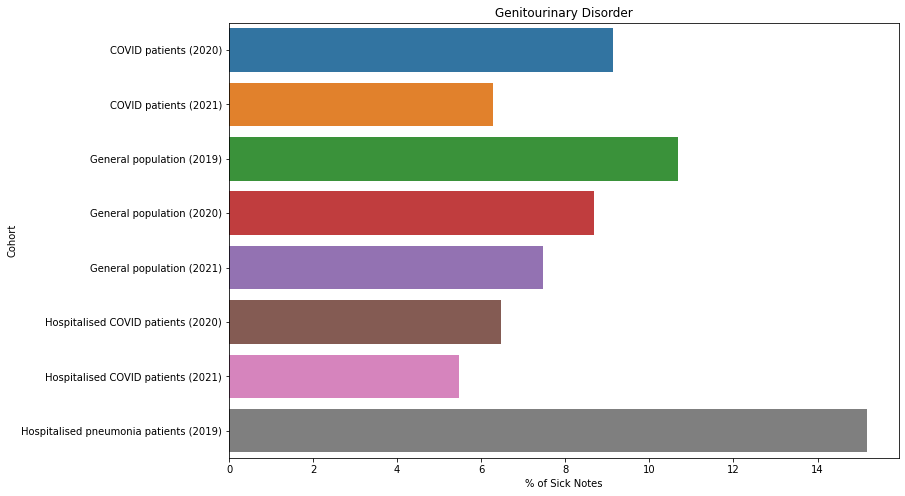

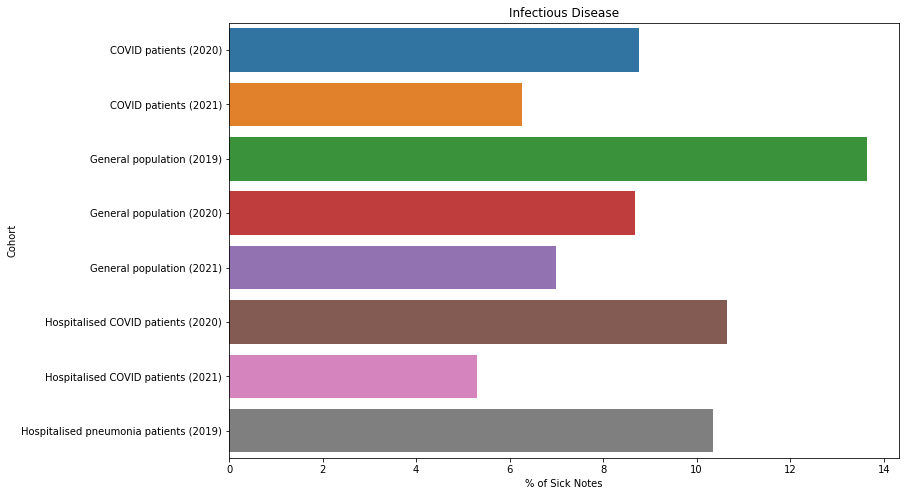

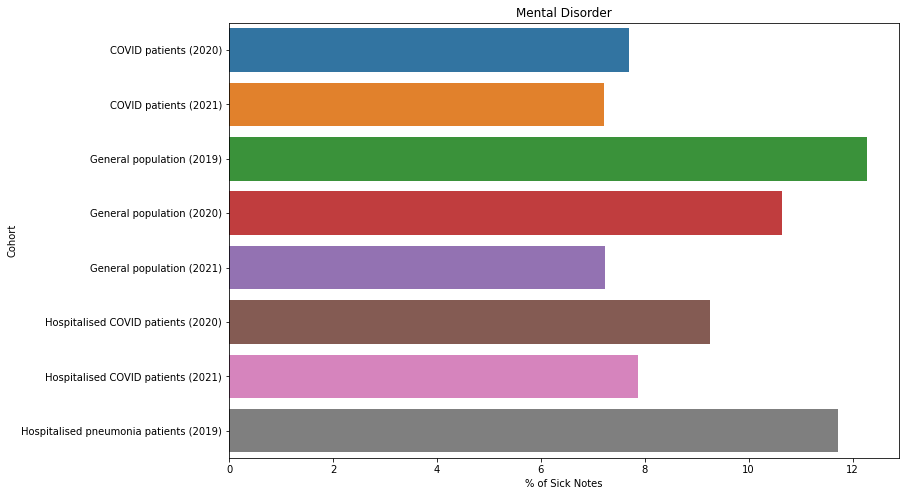

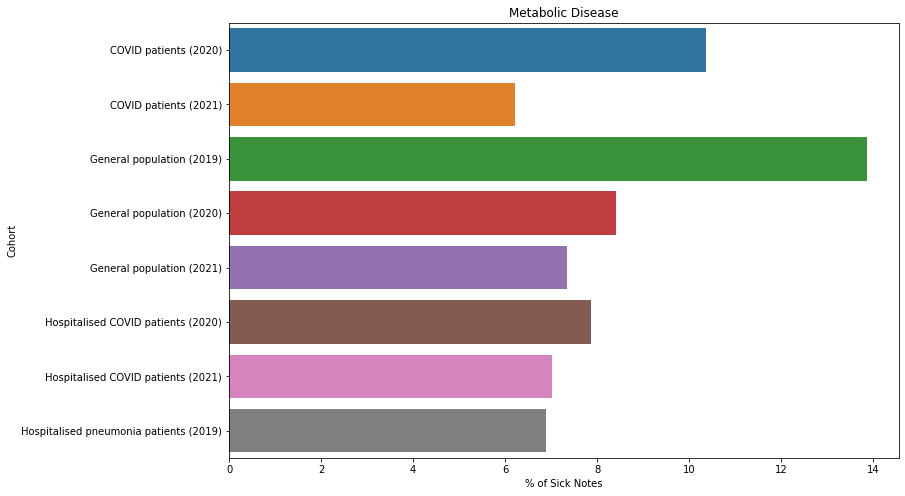

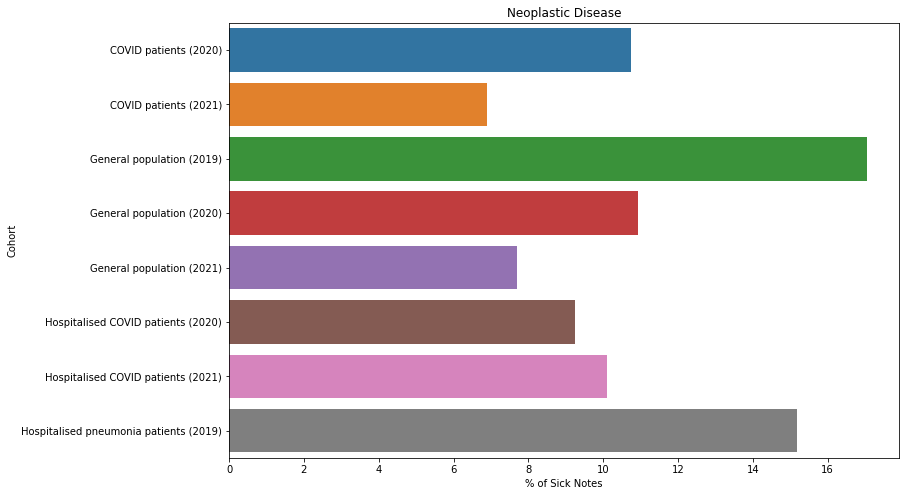

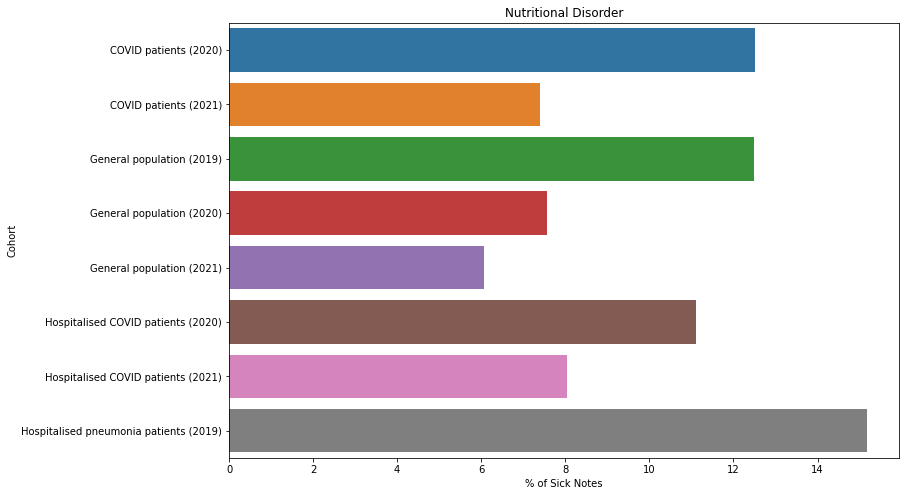

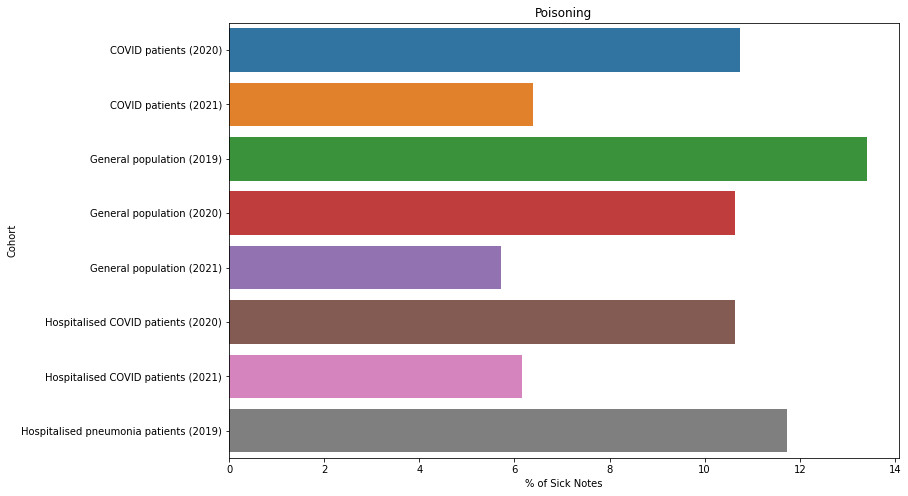

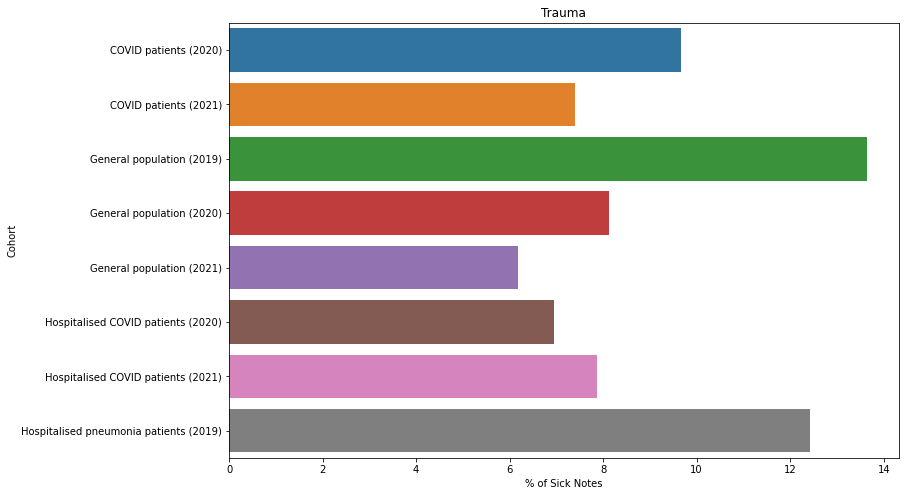

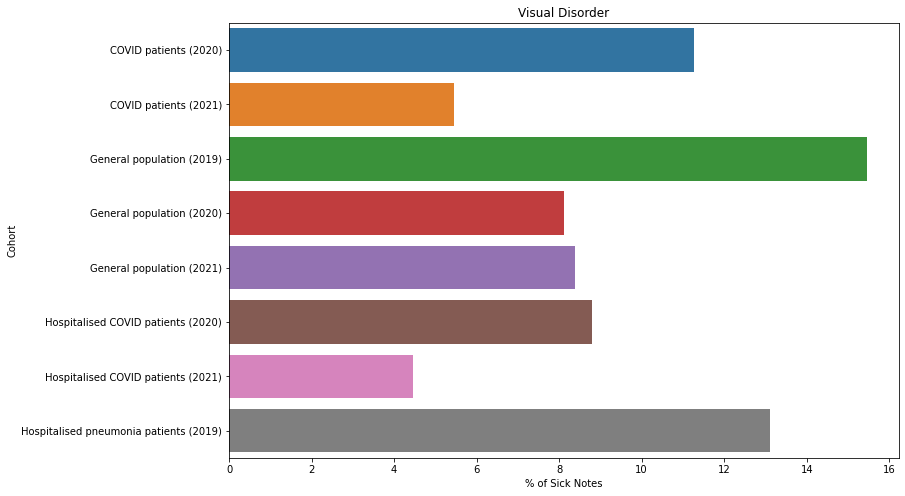

In [16]:
for c in diag_cols:
    # Subset and redact if <= 5 in sick note or diagnosis count
    df_subset = df_diag_sum[['cohort', 'sick_note', 'num_'+c, 'pct_'+c]]
    df_subset.loc[(df_subset['sick_note'] < 5) | (df_subset['num_'+c] < 5), ('num_'+c, 'pct_'+c)] = (0,0)
    try:
        create_plotgrid(c, df_subset)
    except ValueError:
        pass

### Top Codes by Category

In [17]:
# Map categories to codelists
dict_cat_codes = {
    "diag_central_nervous_system": 'central-nervous-system-finding',
    "diag_pregnancy_complication": 'complication-of-pregnancy-childbirth-andor-the-puerperium',
    "diag_congenital_disease": 'congenital-disease',
    "diag_auditory_disorder": 'disorder-of-auditory-system',
    "diag_cardio_disorder": 'disorder-of-cardiovascular-system',
    "diag_bloodcell_disorder": 'disorder-of-cellular-component-of-blood',
    "diag_connective_tissue": 'disorder-of-connective-tissue',
    "diag_digestive_disorder": 'disorder-of-digestive-system',
    "diag_endocrine_disorder": 'disorder-of-endocrine-system',
    "diag_fetus_newborn_disorder": 'disorder-of-fetus-or-newborn',
    "diag_hematopoietic_disorder": 'disorder-of-hematopoietic-structure',
    "diag_immune_disorder": 'disorder-of-immune-function',
    "diag_labor_delivery_disorder": 'disorder-of-labor-delivery',
    "diag_musculoskeletal_disorder": 'disorder-of-musculoskeletal-system',
    "diag_nervous_disorder": 'disorder-of-nervous-system',
    "diag_puerperium_disorder": 'disorder-of-puerperium',
    "diag_respiratory_disorder": 'disorder-of-respiratory-system',
    "diag_skin_disorder": 'disorder-of-skin-andor-subcutaneous-tissue',
    "diag_genitourinary_disorder": 'disorder-of-the-genitourinary-system',
    "diag_infectious_disease": 'infectious-disease',
    "diag_mental_disorder": 'mental-disorder',
    "diag_metabolic_disease": 'metabolic-disease',
    "diag_neoplastic_disease": 'neoplastic-disease',
    "diag_nutritional_disorder": 'nutritional-disorder',
    "diag_poisoning": 'poisoning',
    "diag_trauma": 'traumatic-andor-non-traumatic-injury',
    "diag_visual_disorder": 'visual-system-disorder',
}

In [18]:
# Import codelist to get codenames
def import_codelist(measure):
    fname = dict_cat_codes.get(measure)
    df_codelist = pd.read_csv(f'../codelists/user-kate-mansfield-{fname}-all-descendants.csv')
    return df_codelist

def top_codes(measure):
    # Sum by code
    df_cln_codes = df_clean[['cohort',measure,'population']].rename(columns={'population':'count',measure:'code'})
    df_cln_codes_agg = df_cln_codes.groupby(['cohort','code']).sum().reset_index()

    # Add code names
    df_codelist = import_codelist(measure)
    df_code_sum = df_cln_codes_agg.merge(df_codelist, on='code', how='left')

    # Redact if count <= 5 and limit to top 5 by cohort
    df_code_sum = df_code_sum.loc[df_code_sum['count'] > 5]
    df_code_sum = df_code_sum[['cohort','code','term','count']].reset_index(drop=True)
    df_code_sum = df_code_sum.sort_values(['cohort','count'],ascending=False).groupby(['cohort'],sort=False).head(5).reset_index(drop=True)
    
    # Round to nearest 5 
    df_code_sum['count'] = df_code_sum['count'].apply(lambda x: round_seven(x))
    df_code_sum['code'] = df_code_sum['code'].apply(lambda x: str(int(x)))

    # Display
    title = measure[5:].replace("_", " ").title()
    print(f'Top Codes ({title})')
    display(df_code_sum)
    print('\n')

In [19]:
for c in diag_cols:
    top_codes(c)

Top Codes (Central Nervous System)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised pneumonia patients (2019),10823571000119104,NaN,5
2,Hospitalised pneumonia patients (2019),1010442006,NaN,5
3,Hospitalised COVID patients (2021),106010004,NaN,10
4,Hospitalised COVID patients (2021),1010442006,NaN,10
5,Hospitalised COVID patients (2021),10823571000119104,NaN,10
6,Hospitalised COVID patients (2021),1048491000000106,NaN,5
7,General population (2021),1010442006,NaN,15
8,General population (2021),106010004,NaN,15
9,General population (2021),10294000,NaN,10




Top Codes (Pregnancy Complication)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,Pelvic dystocia AND/OR uterine disorder,15
1,Hospitalised COVID patients (2021),10294000,NaN,10
2,Hospitalised COVID patients (2021),10823571000119104,NaN,10
3,Hospitalised COVID patients (2020),10294000,NaN,5
4,General population (2021),106010004,Pelvic dystocia AND/OR uterine disorder,20
5,General population (2021),1010442006,NaN,15
6,General population (2021),10823571000119104,NaN,15
7,General population (2021),10294000,NaN,10
8,General population (2021),1048491000000106,NaN,5
9,General population (2020),10823571000119104,NaN,10




Top Codes (Congenital Disease)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,10
1,Hospitalised COVID patients (2021),10294000,NaN,10
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10823571000119104,NaN,5
4,Hospitalised COVID patients (2020),106010004,NaN,10
5,Hospitalised COVID patients (2020),1010442006,NaN,5
6,General population (2021),106010004,NaN,25
7,General population (2021),1010442006,NaN,15
8,General population (2021),10294000,NaN,15
9,General population (2021),1048491000000106,NaN,5




Top Codes (Auditory Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,10
1,Hospitalised COVID patients (2021),10294000,NaN,5
2,Hospitalised COVID patients (2021),10823571000119104,NaN,5
3,Hospitalised COVID patients (2020),10294000,NaN,5
4,Hospitalised COVID patients (2020),106010004,NaN,5
5,General population (2021),1010442006,Sensorineural hearing loss of left ear with normal hearing on right side,20
6,General population (2021),10823571000119104,NaN,15
7,General population (2021),106010004,NaN,15
8,General population (2021),10294000,NaN,10
9,General population (2020),106010004,NaN,10




Top Codes (Cardio Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,15
1,Hospitalised COVID patients (2021),10294000,NaN,5
2,Hospitalised COVID patients (2020),106010004,NaN,5
3,General population (2021),106010004,NaN,20
4,General population (2021),10823571000119104,NaN,10
5,General population (2021),1010442006,NaN,10
6,General population (2020),106010004,NaN,15
7,General population (2019),106010004,NaN,10
8,General population (2019),1010442006,NaN,10
9,General population (2019),10823571000119104,NaN,10




Top Codes (Bloodcell Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,15
1,Hospitalised COVID patients (2021),10294000,Reactive mastocytosis,10
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2020),106010004,NaN,5
4,General population (2021),106010004,NaN,20
5,General population (2021),1010442006,NaN,10
6,General population (2021),10823571000119104,NaN,5
7,General population (2021),10294000,Reactive mastocytosis,5
8,General population (2020),106010004,NaN,15
9,General population (2020),10823571000119104,NaN,10




Top Codes (Connective Tissue)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,10
1,Hospitalised COVID patients (2021),10294000,NaN,10
2,Hospitalised COVID patients (2021),1010442006,NaN,5
3,General population (2021),106010004,NaN,15
4,General population (2021),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,10
5,General population (2021),10294000,NaN,5
6,General population (2021),1010442006,NaN,5
7,General population (2021),1048491000000106,NaN,5
8,General population (2020),106010004,NaN,15
9,General population (2019),106010004,NaN,15




Top Codes (Digestive Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised COVID patients (2021),106010004,NaN,10
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10294000,NaN,5
4,Hospitalised COVID patients (2020),10823571000119104,NaN,5
5,General population (2021),106010004,NaN,15
6,General population (2021),10294000,NaN,10
7,General population (2021),1010442006,NaN,10
8,General population (2021),10823571000119104,NaN,10
9,General population (2020),10294000,NaN,10




Top Codes (Endocrine Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10823571000119104,NaN,5
1,Hospitalised COVID patients (2021),10823571000119104,NaN,15
2,Hospitalised COVID patients (2021),10294000,NaN,10
3,Hospitalised COVID patients (2021),106010004,NaN,10
4,Hospitalised COVID patients (2021),1010442006,NaN,5
5,Hospitalised COVID patients (2020),10823571000119104,NaN,10
6,General population (2021),10294000,NaN,20
7,General population (2021),1010442006,NaN,15
8,General population (2021),106010004,NaN,15
9,General population (2021),1048491000000106,NaN,5




Top Codes (Fetus Newborn Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,15
1,Hospitalised COVID patients (2021),10823571000119104,NaN,10
2,Hospitalised COVID patients (2021),10294000,NaN,5
3,Hospitalised COVID patients (2020),106010004,NaN,10
4,Hospitalised COVID patients (2020),1010442006,NaN,5
5,General population (2021),106010004,NaN,15
6,General population (2021),10823571000119104,NaN,15
7,General population (2021),10294000,NaN,10
8,General population (2021),1010442006,NaN,10
9,General population (2020),106010004,NaN,15




Top Codes (Hematopoietic Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006,NaN,10
1,Hospitalised COVID patients (2021),106010004,NaN,15
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10294000,Reactive mastocytosis,5
4,Hospitalised COVID patients (2020),106010004,NaN,10
5,General population (2021),10823571000119104,NaN,15
6,General population (2021),106010004,NaN,15
7,General population (2021),1010442006,NaN,10
8,General population (2021),10294000,Reactive mastocytosis,10
9,General population (2020),10294000,Reactive mastocytosis,5




Top Codes (Immune Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006,NaN,5
1,Hospitalised COVID patients (2021),106010004,NaN,10
2,Hospitalised COVID patients (2021),10823571000119104,NaN,10
3,Hospitalised COVID patients (2021),10294000,Reactive mastocytosis,10
4,Hospitalised COVID patients (2021),1010442006,NaN,5
5,Hospitalised COVID patients (2020),106010004,NaN,5
6,General population (2021),106010004,NaN,15
7,General population (2021),10294000,Reactive mastocytosis,10
8,General population (2021),1010442006,NaN,10
9,General population (2021),10823571000119104,NaN,10




Top Codes (Labor Delivery Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,Pelvic dystocia AND/OR uterine disorder,10
1,Hospitalised COVID patients (2021),1010442006,NaN,15
2,Hospitalised COVID patients (2021),10294000,NaN,10
3,Hospitalised COVID patients (2021),10823571000119104,NaN,10
4,Hospitalised COVID patients (2021),106010004,Pelvic dystocia AND/OR uterine disorder,10
5,Hospitalised COVID patients (2020),1010442006,NaN,10
6,General population (2021),106010004,Pelvic dystocia AND/OR uterine disorder,10
7,General population (2021),1048491000000106,NaN,10
8,General population (2021),10823571000119104,NaN,10
9,General population (2021),1010442006,NaN,10




Top Codes (Musculoskeletal Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised pneumonia patients (2019),10294000,NaN,5
2,Hospitalised pneumonia patients (2019),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,5
3,Hospitalised COVID patients (2021),106010004,NaN,10
4,Hospitalised COVID patients (2021),1048491000000106,NaN,5
5,Hospitalised COVID patients (2020),106010004,NaN,10
6,General population (2021),10294000,NaN,15
7,General population (2021),106010004,NaN,15
8,General population (2021),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,10
9,General population (2021),1010442006,NaN,10




Top Codes (Nervous Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised pneumonia patients (2019),1010442006,NaN,5
2,Hospitalised COVID patients (2021),106010004,NaN,15
3,Hospitalised COVID patients (2021),10823571000119104,NaN,10
4,Hospitalised COVID patients (2021),1010442006,NaN,5
5,Hospitalised COVID patients (2020),1010442006,NaN,5
6,General population (2021),10294000,NaN,15
7,General population (2021),10823571000119104,NaN,15
8,General population (2021),106010004,NaN,15
9,General population (2021),1048491000000106,NaN,5




Top Codes (Puerperium Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),1010442006,NaN,10
1,Hospitalised COVID patients (2021),106010004,NaN,10
2,Hospitalised COVID patients (2021),10823571000119104,NaN,10
3,Hospitalised COVID patients (2020),10294000,NaN,5
4,Hospitalised COVID patients (2020),1010442006,NaN,5
5,Hospitalised COVID patients (2020),1048491000000106,NaN,5
6,General population (2021),1010442006,NaN,15
7,General population (2021),10294000,NaN,15
8,General population (2021),106010004,NaN,10
9,General population (2021),10823571000119104,NaN,10




Top Codes (Respiratory Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),10823571000119104,NaN,10
1,Hospitalised COVID patients (2021),1048491000000106,NaN,5
2,Hospitalised COVID patients (2020),10823571000119104,NaN,5
3,Hospitalised COVID patients (2020),10294000,NaN,5
4,General population (2021),106010004,NaN,20
5,General population (2021),10294000,NaN,15
6,General population (2021),10823571000119104,NaN,10
7,General population (2021),1048491000000106,NaN,10
8,General population (2020),106010004,NaN,5
9,General population (2020),1010442006,NaN,5




Top Codes (Skin Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),10823571000119104,NaN,10
1,Hospitalised COVID patients (2021),1010442006,NaN,10
2,Hospitalised COVID patients (2021),106010004,NaN,5
3,Hospitalised COVID patients (2020),106010004,NaN,10
4,General population (2021),106010004,NaN,15
5,General population (2021),10823571000119104,NaN,10
6,General population (2021),10294000,NaN,10
7,General population (2021),1048491000000106,NaN,10
8,General population (2021),1010442006,NaN,5
9,General population (2020),106010004,NaN,10




Top Codes (Genitourinary Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised pneumonia patients (2019),1010442006,NaN,5
2,Hospitalised COVID patients (2021),106010004,NaN,10
3,Hospitalised COVID patients (2021),10823571000119104,NaN,5
4,General population (2021),106010004,NaN,20
5,General population (2021),10294000,NaN,15
6,General population (2021),1010442006,NaN,10
7,General population (2021),10823571000119104,NaN,10
8,General population (2021),1048491000000106,Acute kidney injury due to acute tubular necrosis due to sepsis,5
9,General population (2020),1010442006,NaN,10




Top Codes (Infectious Disease)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,10
1,Hospitalised COVID patients (2021),10294000,NaN,5
2,Hospitalised COVID patients (2021),1010442006,NaN,5
3,Hospitalised COVID patients (2021),10823571000119104,NaN,5
4,Hospitalised COVID patients (2020),1010442006,NaN,10
5,Hospitalised COVID patients (2020),10294000,NaN,5
6,General population (2021),106010004,NaN,15
7,General population (2021),10823571000119104,NaN,15
8,General population (2021),10294000,NaN,10
9,General population (2021),1010442006,NaN,10




Top Codes (Mental Disorder)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,15
1,Hospitalised COVID patients (2021),10823571000119104,NaN,10
2,Hospitalised COVID patients (2021),10294000,NaN,10
3,Hospitalised COVID patients (2021),1048491000000106,NaN,5
4,Hospitalised COVID patients (2021),1010442006,NaN,5
5,Hospitalised COVID patients (2020),1010442006,NaN,5
6,General population (2021),106010004,NaN,20
7,General population (2021),10823571000119104,NaN,15
8,General population (2021),1010442006,NaN,10
9,General population (2021),10294000,NaN,10




Top Codes (Metabolic Disease)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),106010004,NaN,15
1,Hospitalised COVID patients (2021),10823571000119104,NaN,10
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10294000,NaN,5
4,Hospitalised COVID patients (2020),10823571000119104,NaN,5
5,General population (2021),106010004,NaN,20
6,General population (2021),1010442006,NaN,15
7,General population (2021),10823571000119104,NaN,15
8,General population (2021),10294000,NaN,10
9,General population (2020),1048491000000106,NaN,10




Top Codes (Neoplastic Disease)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10294000,NaN,5
1,Hospitalised COVID patients (2021),106010004,NaN,20
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10294000,NaN,10
4,Hospitalised COVID patients (2021),10823571000119104,NaN,10
5,Hospitalised COVID patients (2021),1048491000000106,NaN,5
6,Hospitalised COVID patients (2020),106010004,NaN,10
7,General population (2021),106010004,NaN,20
8,General population (2021),10823571000119104,NaN,15
9,General population (2021),10294000,NaN,10




Top Codes (Nutritional Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised pneumonia patients (2019),10294000,NaN,5
2,Hospitalised COVID patients (2021),106010004,NaN,15
3,Hospitalised COVID patients (2021),10294000,NaN,10
4,Hospitalised COVID patients (2021),1010442006,NaN,10
5,Hospitalised COVID patients (2021),10823571000119104,NaN,5
6,Hospitalised COVID patients (2021),1048491000000106,NaN,5
7,Hospitalised COVID patients (2020),1010442006,NaN,5
8,General population (2021),106010004,NaN,15
9,General population (2021),1010442006,NaN,15




Top Codes (Poisoning)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,NaN,5
1,Hospitalised COVID patients (2021),106010004,NaN,10
2,Hospitalised COVID patients (2021),1010442006,NaN,10
3,Hospitalised COVID patients (2021),10823571000119104,NaN,5
4,Hospitalised COVID patients (2021),10294000,NaN,5
5,Hospitalised COVID patients (2020),10294000,NaN,10
6,Hospitalised COVID patients (2020),1010442006,NaN,5
7,General population (2021),10823571000119104,NaN,15
8,General population (2021),10294000,NaN,10
9,General population (2021),106010004,NaN,10




Top Codes (Trauma)


,cohort,code,term,count
0,Hospitalised COVID patients (2021),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,10
1,Hospitalised COVID patients (2021),1010442006,NaN,10
2,Hospitalised COVID patients (2021),106010004,NaN,10
3,Hospitalised COVID patients (2021),1048491000000106,NaN,10
4,Hospitalised COVID patients (2020),1010442006,NaN,5
5,General population (2021),106010004,NaN,20
6,General population (2021),1010442006,NaN,10
7,General population (2021),10294000,NaN,10
8,General population (2021),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,10
9,General population (2021),1048491000000106,NaN,5




Top Codes (Visual Disorder)


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10823571000119104,NaN,5
1,Hospitalised pneumonia patients (2019),1010442006,NaN,5
2,Hospitalised COVID patients (2021),10823571000119104,NaN,10
3,Hospitalised COVID patients (2021),106010004,NaN,5
4,Hospitalised COVID patients (2021),1010442006,NaN,5
5,Hospitalised COVID patients (2020),106010004,NaN,5
6,General population (2021),106010004,NaN,30
7,General population (2021),10294000,NaN,15
8,General population (2021),1010442006,NaN,15
9,General population (2021),10823571000119104,NaN,10


### Percentage of Sick Notes Across All Diagnostic Categories

In [20]:
# Limit columns
df_sick_notes = df_clean[['cohort','sick_note'] + diag_cols]

# Reshape long
df_sick_notes_long = pd.melt(df_sick_notes, id_vars=['cohort','sick_note'], value_vars=diag_cols).drop(columns=['variable'])
df_sick_notes_long = df_sick_notes_long.loc[~df_sick_notes_long.value.isna()].reset_index(drop=True)

# Create sums and percentages
df_code_sum = df_sick_notes_long.groupby(['cohort','value']).sum().reset_index()
df_cohort_sum = df_code_sum[['cohort','sick_note']].groupby(['cohort']).sum().reset_index().rename(columns={'sick_note':'total_sick_note'})
df_all_diag = df_code_sum.merge(df_cohort_sum, on='cohort', how='left')
df_all_diag['pct_diag_all_codes'] = (df_all_diag['sick_note']/df_all_diag['total_sick_note'])*100

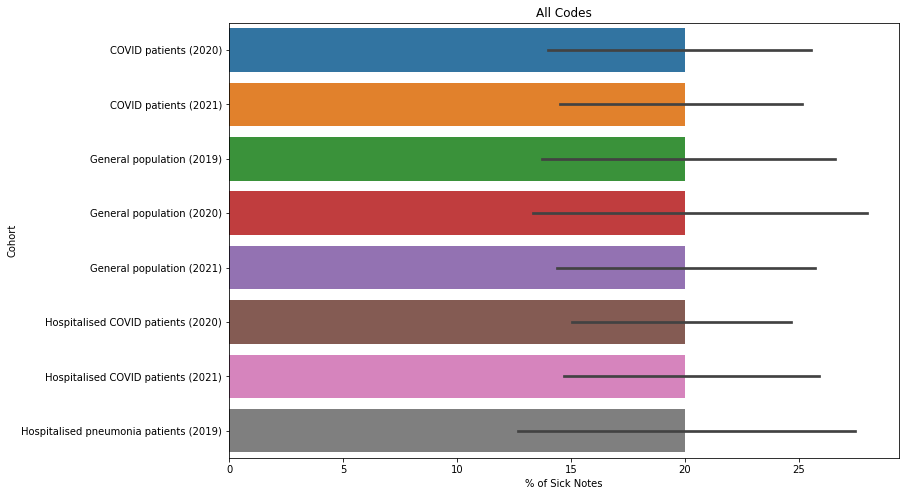

In [21]:
create_plotgrid('diag_all_codes',df_all_diag)

### Top Codes by All Diagnostic Categories

In [22]:
# Import and append codelists
li_diag_cl = []

for k in dict_cat_codes:
    df_temp = import_codelist(k)
    li_diag_cl.append(df_temp)
    
df_codelists = pd.concat(li_diag_cl, ignore_index=True).drop_duplicates().reset_index(drop=True)

In [23]:
# Merge code names
df_all_code = df_all_diag[['cohort','value','sick_note']].rename(columns={'value':'code','sick_note':'count'})
df_all_code_names = df_all_code.merge(df_codelists, on='code', how='left')[['cohort','code','term','count']]

# Restrict to top 5 (redact if count <= 5)
df_all_code_names = df_all_code_names.loc[df_all_code_names['count'] > 5]
df_all_code_names = df_all_code_names.sort_values(['cohort','count'],ascending=False).groupby(['cohort'],sort=False).head(5).reset_index(drop=True)

# Round to nearest 5 
df_all_code_names['count'] = df_all_code_names['count'].apply(lambda x: round_seven(x))
df_all_code_names['code'] = df_all_code_names['code'].apply(lambda x: str(int(x)))

In [24]:
print('Top Codes')
display(df_all_code_names)

Top Codes


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004,Pelvic dystocia AND/OR uterine disorder,55
1,Hospitalised pneumonia patients (2019),1010442006,Sensorineural hearing loss of left ear with normal hearing on right side,35
2,Hospitalised pneumonia patients (2019),10294000,Reactive mastocytosis,35
3,Hospitalised pneumonia patients (2019),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,30
4,Hospitalised pneumonia patients (2019),1048491000000106,Acute kidney injury due to acute tubular necrosis due to sepsis,10
5,Hospitalised COVID patients (2021),106010004,Pelvic dystocia AND/OR uterine disorder,230
6,Hospitalised COVID patients (2021),10823571000119104,Open mallet fracture of distal phalanx of ring finger of left hand,165
7,Hospitalised COVID patients (2021),1010442006,Sensorineural hearing loss of left ear with normal hearing on right side,160
8,Hospitalised COVID patients (2021),10294000,Reactive mastocytosis,140
9,Hospitalised COVID patients (2021),1048491000000106,Acute kidney injury due to acute tubular necrosis due to sepsis,85
